In [1]:
import sknetwork as sn
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.metrics import f1_score as F1
from egosplit_sknetwork import EgoSplit
from partition_sknetwork import ECG
import matplotlib.pyplot as plt

import os

import CAS
import community_evaluation as ce

In [2]:
# We tend to get divide by 0 warnings, but they are corretly set to inf
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# Test performance of clustering algorithms while allowing for outliers and overlapping communities.

# Ego-split + CAS
# ECG + CAS
# HSLC (edge version)

# compare with F1s 1/(1/F1(labels, predict) + 1/F1(predict, labels))

In [3]:
abcd_path = "~/Research/ABCDGraphGenerator.jl/utils/"
this_path = "~/Research/CAS/experiments/"
julia = "julia "


def _run_julia_abcd(
    n,
    xi,
    eta,
    nout,
    rng=None,
    gamma=2.5,
    delta=5,
    Delta=None,
    s=50,
    S=None,
    beta=1.5,
    d=8,
    rho=0.0,
):
    if rng is None:
        rng = np.random.default_rng()
    rdm = str(rng.choice(100000))
    if Delta is None:
        Delta = int(n**0.5)
    if S is None:
        S = int(n**0.767)
    if nout <= 0:
        raise ValueError("Cannot parse without outliers")

    config = f"""seed = "{rdm}"                   # RNG seed, use "" for no seeding
n = "{n}"                   # number of vertices in graph
nout = "{nout}"                  # number of vertices in graph that are outliers
t1 = "{gamma}"                      # power-law exponent for degree distribution
d_min = "{delta}"                   # minimum degree
d_max = "{Delta}"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "{beta}"                      # power-law exponent for cluster size distribution
c_min = "{s}"                  # minimum cluster size after growing
c_max = "{S}"                # maximum cluster size after growing
c_max_iter = "1000"           # maximum number of iterations for sampling cluster sizes
xi = "{xi}"                    # fraction of edges to fall in background graph
eta = "{eta}"                   # average number of community per community node
d = "{d}"                       # dimensionality of latent space
rho = "{rho}"                   # correlation between degree and number of communities node is in
degreefile = "deg_{rdm}.dat"        # name of file do generate that contains vertex degrees
communitysizesfile = "cs_{rdm}.dat" # name of file do generate that contains community sizes
communityfile = "com_{rdm}.dat"     # name of file do generate that contains assignments of vertices to communities
networkfile = "edge_{rdm}.dat" """
    config_file = f"config_{rdm}.dat"
    with open(config_file, "w") as f:
        print(config, file=f)
    cmd = julia + abcd_path + "abcd_oo_sampler.jl " + this_path + config_file
    os.system(cmd + " >/dev/null 2>&1")

    adjacency = sn.data.from_csv(f"edge_{rdm}.dat")
    adjacency = adjacency[1:][:, 1:]
    list_of_coms = []
    n_coms = 0
    with open(f"com_{rdm}.dat", "r") as file:
        for line in file:
            # each line has the format: node_id\t[a,b,c]\n
            # for this node belonging to communities a,b,c
            # if there are outliers then they have community [-1]
            # node_id counts up starting at 0
            x = line.split("\t")[1].rstrip()[1:-1]  # gets a,b,c
            x_coms = [int(y) for y in x.split(",")]
            list_of_coms.append(np.array(x_coms))
            n_coms = max(n_coms, max(x_coms) - 1)

    labels = sp.lil_matrix((adjacency.shape[0], n_coms), dtype="bool")
    for x, x_coms in enumerate(list_of_coms):
        if x_coms[0] == 1:
            continue
        labels[x, x_coms - 2] = True
    labels = labels.transpose().tocsr()

    cmd = f"rm *_{rdm}.dat"
    os.system(cmd + " >/dev/null 2>&1")

    return adjacency, labels

In [8]:
def cluster_f1s(labels, predict, drop_outliers=False):
    if labels.shape[0] == 0 or predict.shape[0] == 0:  # No clusters
        return 0

    # Drop nodes with no clusters.
    if drop_outliers:
        labels = labels.transpose().tocsr()
        label_outlier = labels.getnnz(1) == 0
        predict = predict.transpose().tocsr()
        predict_outlier = predict.getnnz(1) == 0
        outlier = np.bitwise_or(label_outlier, predict_outlier)
        labels = labels[~outlier]
        labels = labels.transpose().tocsr()
        predict = predict[~outlier]
        predict = predict.transpose().tocsr()

    label_props = np.asarray(labels.sum(axis=1)).reshape(-1)
    label_props = label_props / np.sum(label_props)
    predict_props = np.asarray(predict.sum(axis=1)).reshape(-1)
    predict_props = predict_props / np.sum(predict_props)

    overlap = predict.astype("float64") * labels.transpose().astype("float64")
    precision = overlap.multiply(1 / predict.sum(axis=1))
    recall = overlap.multiply(1 / labels.sum(axis=1).reshape(-1))
    denom = precision + recall
    denom.data = 1 / denom.data
    f1 = 2 * precision.multiply(recall).multiply(denom)
    predict_f1 = f1.max(axis=1).toarray().reshape(-1)
    predict_average = np.sum(predict_f1 * predict_props)

    labels_f1 = f1.max(axis=0).toarray().reshape(-1)
    labels_average = np.sum(labels_f1 * label_props)

    return 2 / (1 / predict_average + 1 / labels_average)

In [5]:
# Threshold effect on ABCD+o2 benchmark
# threshold vs non-outlier ecc, threshold vs % outliers, threshold vs outlier f1
# fix xi = 0.5, eta=1.5, nout = 20%

In [6]:
REP = 10
n = 10000
ief_thresholds = np.linspace(0.1, 0.4, 7)
p_thresholds = np.linspace(0.9, 0.999, 7)

# Store (F1, % Outlier, F1) in first axis, theshold in second axis, REP in third axis
ief = np.empty((3, len(ief_thresholds), REP))
nief = np.empty((3, len(ief_thresholds), REP))
p = np.empty((3, len(p_thresholds), REP))

with tqdm(total=len(ief_thresholds) * REP) as pbar:
    for i in range(REP):
        adjacency, labels = _run_julia_abcd(n, 0.4, 1.5, int(n / 5), rng=None)
        is_outlier = labels.getnnz(0) == 0
        predict = ECG().fit_predict(adjacency)
        #print("Made Graph")
        for j, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
            #print("IEF", t1)
            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, only_remove=False
            ).fit_predict(predict, adjacency)
            ief[1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            ief[2, j, i] = F1(is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0)
            ief[0, j, i] = cluster_f1s(labels, cas_predict, drop_outliers=True)
            #print("NIEF", t1)
            cas_predict = CAS.CASPostProcesser(
                score="nief", threshold=t1, only_remove=False
            ).fit_predict(predict, adjacency)
            nief[1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            nief[2, j, i] = F1(is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0)
            nief[0, j, i] = cluster_f1s(labels, cas_predict, drop_outliers=True)
            #print("P", t2)
            cas_predict = CAS.CASPostProcesser(
                score="p", threshold=t2, only_remove=False
            ).fit_predict(predict, adjacency)
            p[1, j, i] = np.sum(cas_predict.getnnz(0) == 0) / n
            p[2, j, i] = F1(is_outlier, cas_predict.getnnz(0) == 0, zero_division=0.0)
            p[0, j, i] = cluster_f1s(labels, cas_predict, drop_outliers=True)

            pbar.update()

  6%|▌         | 4/70 [20:48<4:40:42, 255.18s/it] /var/folders/5s/s9kq6m214mg0gjl81gfw4bv00000gn/T/ipykernel_14971/3180274188.py:23: RuntimeWarning: divide by zero encountered in divide
  recall = overlap.multiply(1 / labels.sum(axis=1).reshape(-1))
  7%|▋         | 5/70 [22:02<3:25:29, 189.68s/it]/var/folders/5s/s9kq6m214mg0gjl81gfw4bv00000gn/T/ipykernel_14971/3180274188.py:23: RuntimeWarning: divide by zero encountered in divide
  recall = overlap.multiply(1 / labels.sum(axis=1).reshape(-1))
/var/folders/5s/s9kq6m214mg0gjl81gfw4bv00000gn/T/ipykernel_14971/3180274188.py:23: RuntimeWarning: divide by zero encountered in divide
  recall = overlap.multiply(1 / labels.sum(axis=1).reshape(-1))
  9%|▊         | 6/70 [22:44<2:28:43, 139.43s/it]/var/folders/5s/s9kq6m214mg0gjl81gfw4bv00000gn/T/ipykernel_14971/3180274188.py:23: RuntimeWarning: divide by zero encountered in divide
  recall = overlap.multiply(1 / labels.sum(axis=1).reshape(-1))
 19%|█▊        | 13/70 [56:24<3:08:05, 197.99s/it]/v

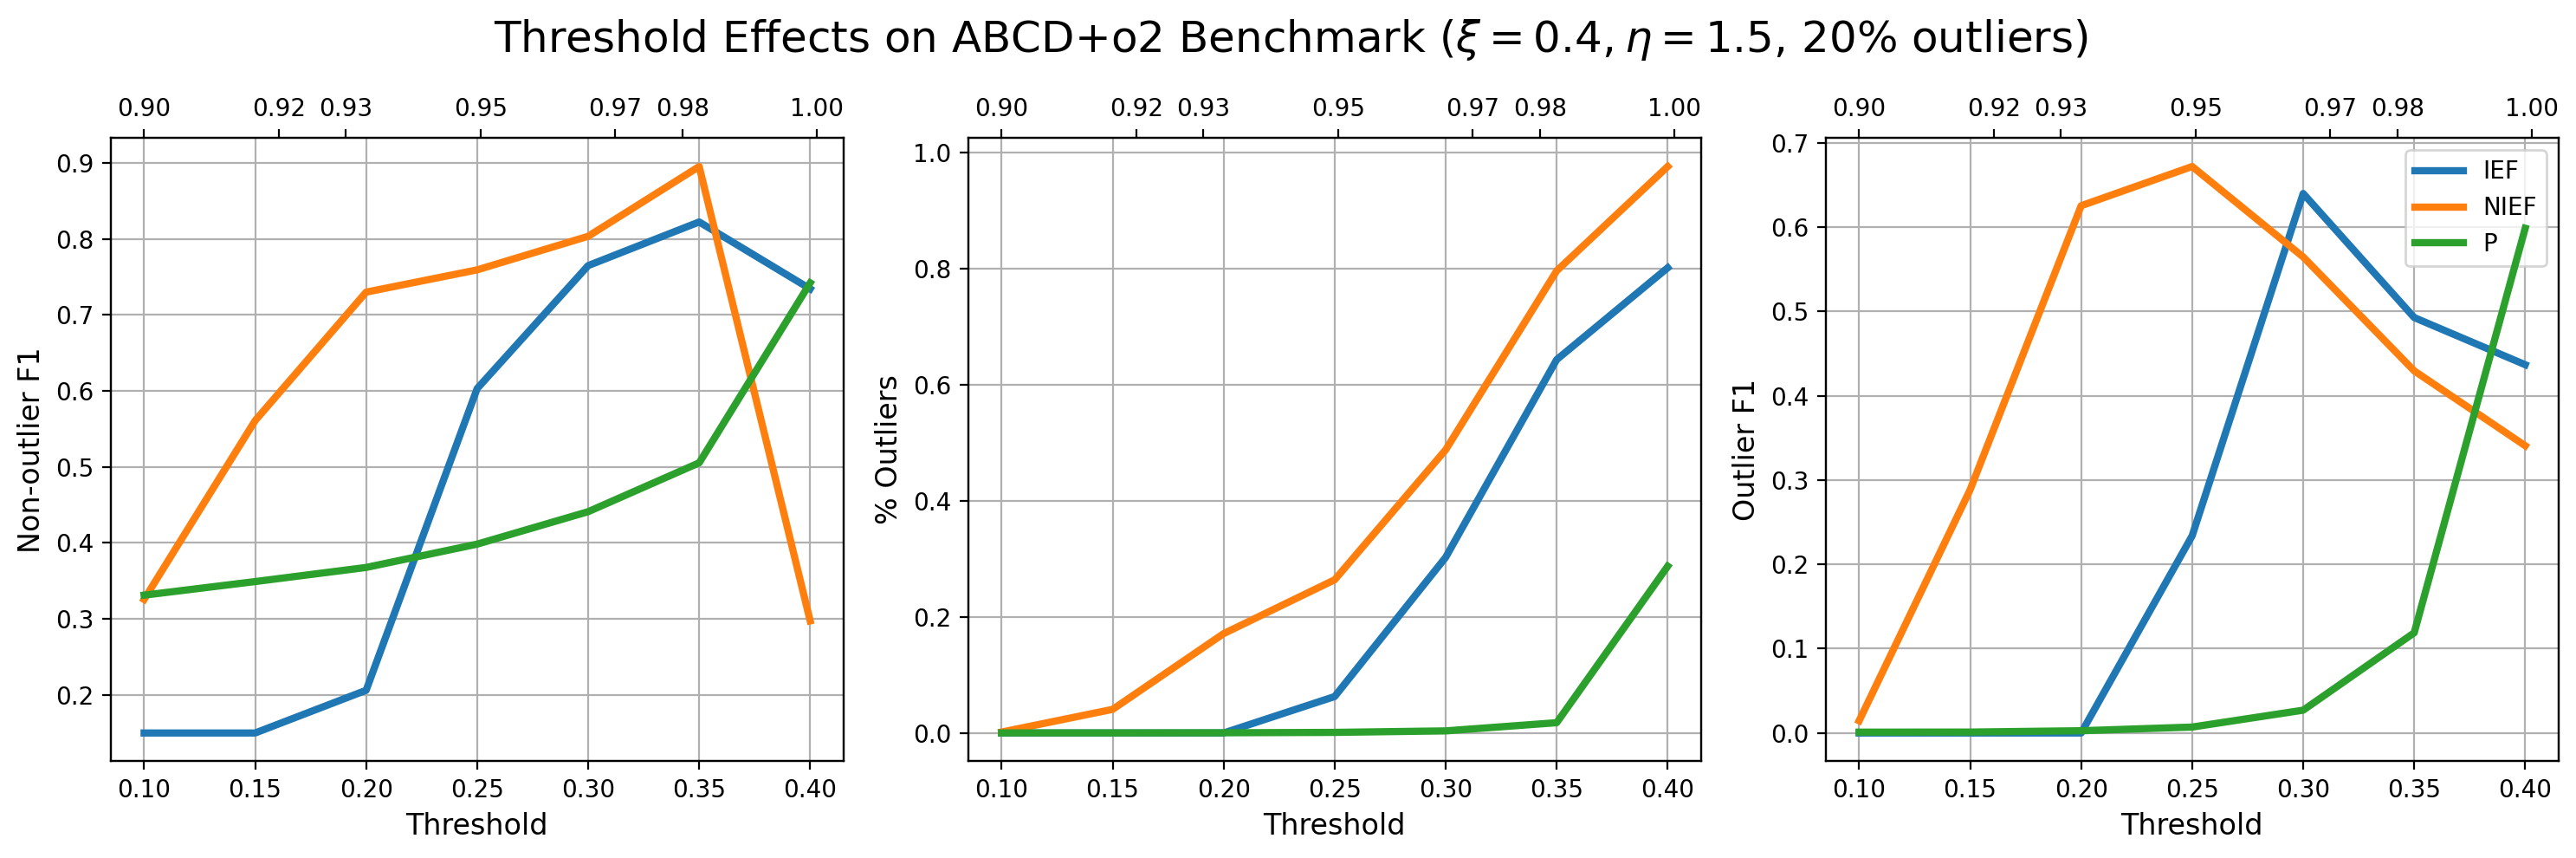

In [7]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

fig, axs = plt.subplots(1, 3)
for i in range(3):
    lines = []
    twy = axs[i].twiny()

    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[i, :, :], axis=1),
        linewidth=3,
        label="IEF",
        c=colors[0],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[i, :, :], axis=1),
        linewidth=3,
        label="NIEF",
        c=colors[1],
    )
    lines += twy.plot(
        p_thresholds, np.mean(p[i, :, :], axis=1), label="P", linewidth=3, c=colors[2]
    )
    labels = [l.get_label() for l in lines]

    # Align tick marks, 5 looks good
    n_ticks = 7
    ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
    axs[i].set_xticks(ief_ticks)
    p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
    twy.set_xticks(p_ticks)
    axs[i].grid()

axs[0].set_ylabel("Non-outlier F1", fontsize=12)
axs[1].set_ylabel("% Outliers", fontsize=12)
axs[2].set_ylabel("Outlier F1", fontsize=12)
axs[0].set_xlabel("Threshold", fontsize=12)
axs[1].set_xlabel("Threshold", fontsize=12)
axs[2].set_xlabel("Threshold", fontsize=12)
axs[2].legend(lines, labels)
plt.suptitle(
    f"Threshold Effects on ABCD+o2 Benchmark " + r"$(\xi=0.4, \eta=1.5$, 20% outliers)",
    fontsize=18,
)

fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.set_dpi(200)
fig.tight_layout()

## Real Graphs

In [3]:
def load_graph(name):
    adjacency = sp.load_npz(f"data/{name}_adjacency.npz")
    try:
        labels = np.load(f"data/{name}_labels.npy")
        labels_indptr, labels_indices, labels_data = CAS.cas_._labels_array_to_matrix(labels)
        labels = sp.csr_matrix((labels_data, labels_indices, labels_indptr), shape=(len(labels_indptr)-1, len(labels)))
        labels.data[:] = True
    except FileNotFoundError as e:
        try:
            labels = sp.load_npz(f"data/{name}_labels.npz")
        except FileNotFoundError as e:
            raise ValueError("Can't find labels file as npy or npz :(")
    return adjacency, labels

In [5]:
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
ief_thresholds = np.linspace(0.1, 0.5, 10)
#p_thresholds = np.linspace(0.9, 0.999, 10)

# Store (Cluster F1, Non-Outlier Cluster F1, % Outlier) in first axis, theshold in second axis, REP in third axis
ief = np.empty((len(graphs), 3, len(ief_thresholds)))
nief = np.empty((len(graphs),3, len(ief_thresholds)))
ecg = np.empty((len(graphs), 3, len(ief_thresholds)))


for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    n = adjacency.shape[0]
    if sp.issparse(labels):
        is_outlier = labels.getnnz(0) == 0
    else:
        is_outlier = labels == -1
    ecgo = ECG()
    predict = ecgo.fit_predict(adjacency)
    print("CAS PostProcessing")
    with tqdm(total=len(ief_thresholds)) as pbar:
        for j, t in enumerate(ief_thresholds):
            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t, only_remove=False).fit_predict(
                predict, adjacency
            )
            ief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ief[i, 2, j] = np.sum(cas_predict.getnnz(0) == 0) / n

            cas_predict = CAS.CASPostProcesser(score="nief", threshold=t, only_remove=False).fit_predict(
                predict, adjacency
            )
            nief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            nief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            nief[i, 2, j] = np.sum(cas_predict.getnnz(0) == 0) / n

            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t, only_remove=False).fit_predict(
                predict, ecgo.weights
            )
            ecg[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ecg[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ecg[i, 2, j] = np.sum(cas_predict.getnnz(0) == 0) / n

            pbar.update()

football
CAS PostProcessing


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


eu-core
CAS PostProcessing


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


as
CAS PostProcessing


  0%|          | 0/10 [10:03<?, ?it/s]


SystemError: CPUDispatcher(<function _post_process at 0x13e8525c0>) returned a result with an exception set

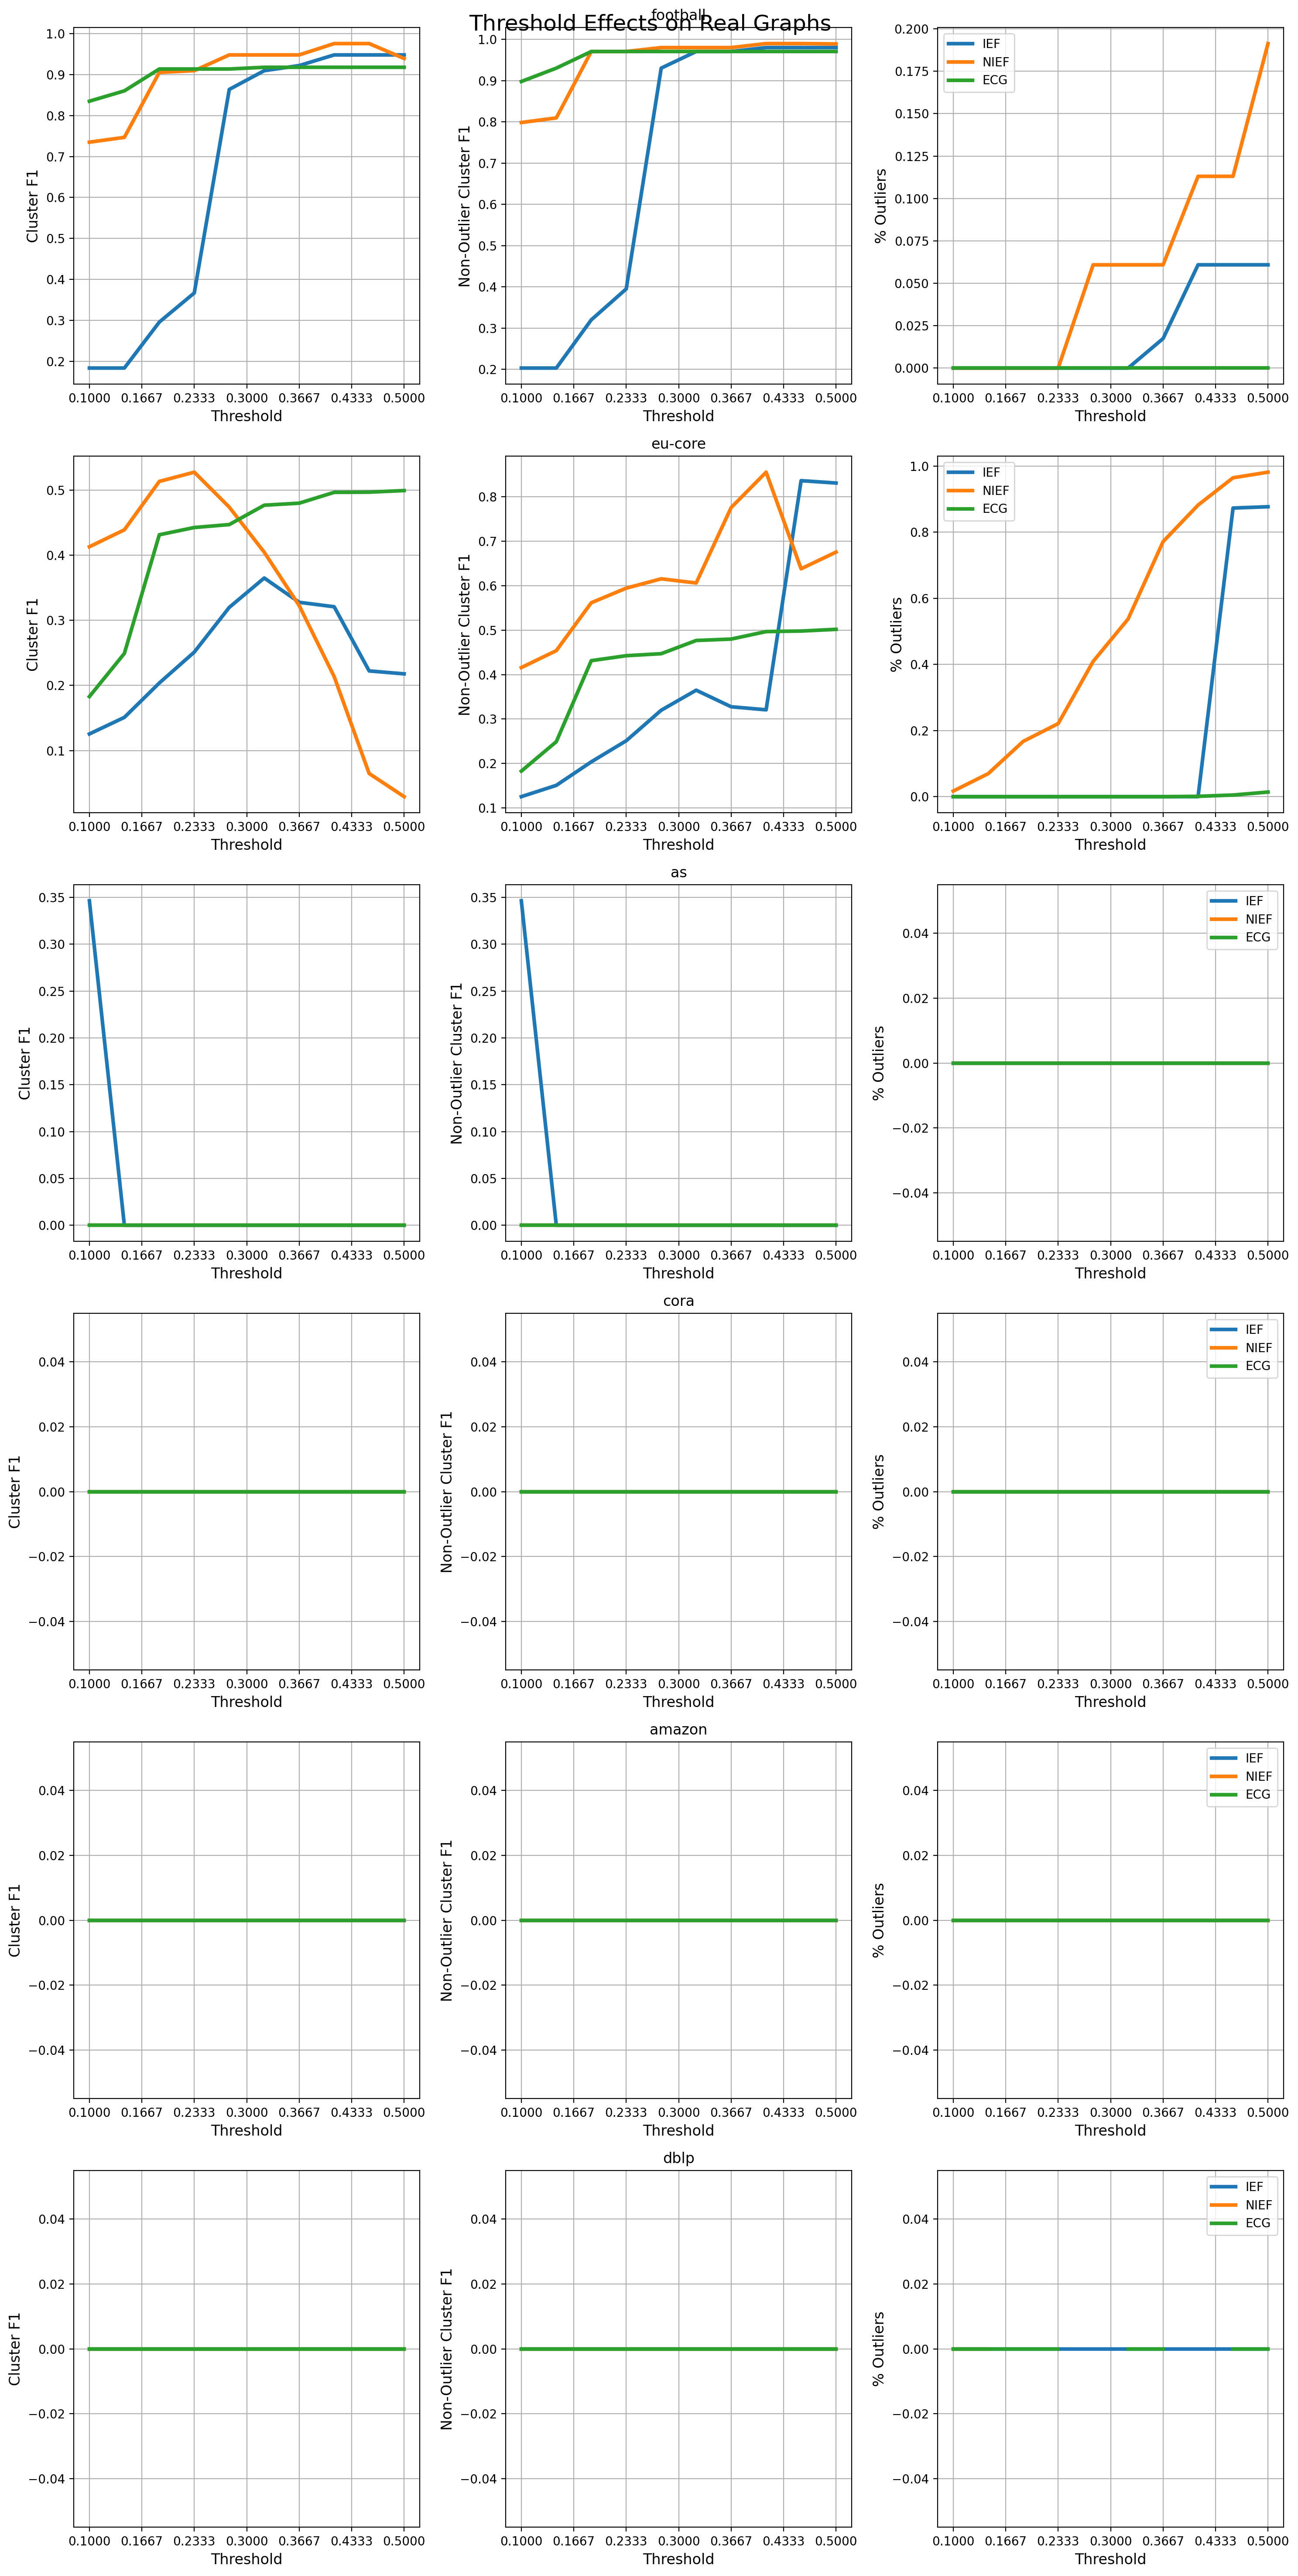

In [9]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

fig, axs = plt.subplots(len(graphs), 3)
fig.subplots_adjust(top=0.9)  # Make room for suptitle
for i in range(len(graphs)):
    for j in range(3):
        lines = []
        # twy = axs[i,j].twiny()

        lines += axs[i,j].plot(
            ief_thresholds,
            ief[i, j, :],
            linewidth=3,
            label="IEF",
            c=colors[0],
        )
        lines += axs[i,j].plot(
            ief_thresholds,
            nief[i, j, :],
            linewidth=3,
            label="NIEF",
            c=colors[1],
        )
        lines += axs[i,j].plot(
            ief_thresholds,
            ecg[i, j, :],
            linewidth=3,
            label="ECG",
            c=colors[2],
        )
        # lines += twy.plot(
        #     p_thresholds, p[i, j, :], label="P", linewidth=3, c=colors[2]
        # )
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 7
        ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        # p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
        # twy.set_xticks(p_ticks)
        axs[i,j].grid()

    axs[i,0].set_ylabel("Cluster F1", fontsize=12)
    axs[i,1].set_ylabel("Non-Outlier Cluster F1", fontsize=12)
    axs[i,2].set_ylabel("% Outliers", fontsize=12)
    axs[i,0].set_xlabel("Threshold", fontsize=12)
    axs[i,1].set_xlabel("Threshold", fontsize=12)
    axs[i,2].set_xlabel("Threshold", fontsize=12)
    axs[i,2].legend(lines, labels)
    axs[i,1].set_title(graphs[i])
plt.suptitle(
    f"Threshold Effects on Real Graphs",
    fontsize=18,
)
fig = plt.gcf()
fig.set_size_inches(15, 5*len(graphs))
fig.set_dpi(200)
fig.tight_layout()